In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, recall_score
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

sns.set_theme(context='notebook', style='darkgrid', font_scale=2)

In [2]:
data = pd.read_csv("../data/raw/heart.csv")

In [3]:
train, test = train_test_split(data, test_size=0.2, random_state=1984)

In [4]:
train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
162,41,1,1,120,157,0,1,182,0,0.0,2,0,2,1
227,35,1,0,120,198,0,1,130,1,1.6,1,0,3,0
224,54,1,0,110,239,0,1,126,1,2.8,1,1,3,0
142,42,0,2,120,209,0,1,173,0,0.0,1,0,2,1
43,53,0,0,130,264,0,0,143,0,0.4,1,0,2,1


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242 entries, 162 to 220
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       242 non-null    int64  
 1   sex       242 non-null    int64  
 2   cp        242 non-null    int64  
 3   trestbps  242 non-null    int64  
 4   chol      242 non-null    int64  
 5   fbs       242 non-null    int64  
 6   restecg   242 non-null    int64  
 7   thalach   242 non-null    int64  
 8   exang     242 non-null    int64  
 9   oldpeak   242 non-null    float64
 10  slope     242 non-null    int64  
 11  ca        242 non-null    int64  
 12  thal      242 non-null    int64  
 13  target    242 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 28.4 KB


In [6]:
data.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

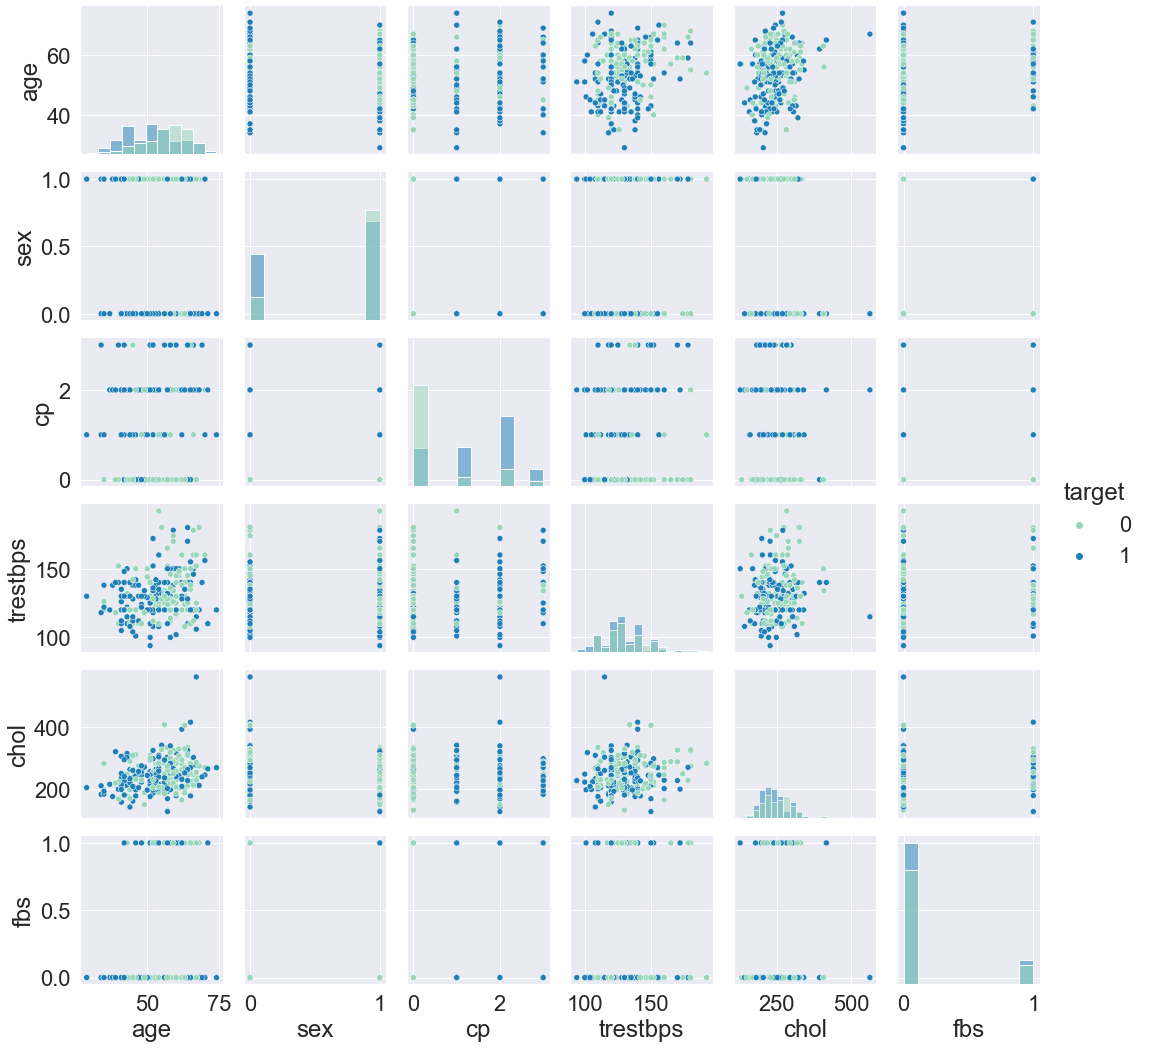

In [7]:
sns.pairplot(pd.concat((train.iloc[:, :6], train.iloc[:, -1]), axis=1), 
             hue="target", diag_kind="hist", palette="YlGnBu")

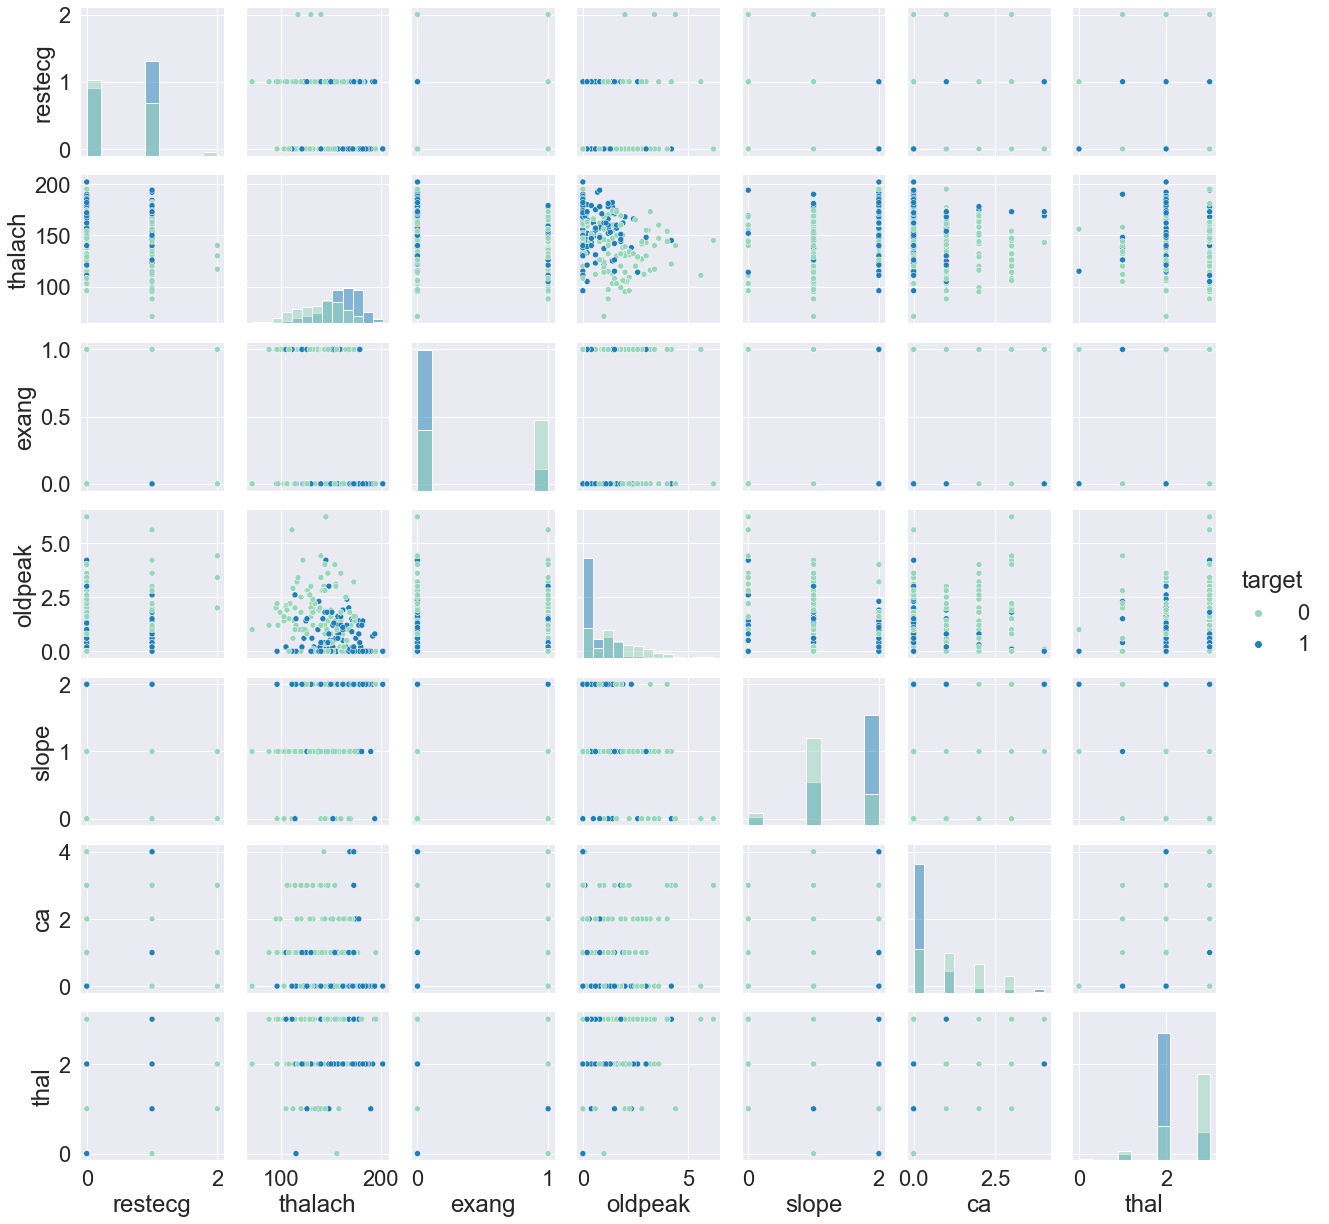

In [8]:
sns.pairplot(train.iloc[:, 6:], hue="target", 
             diag_kind="hist", palette="YlGnBu")

In [9]:
print("Proportion of the positive class: ", data["target"].sum() / data.shape[0])

Proportion of the positive class:  0.5445544554455446


There are 14 features, 8 of which are categorical. From the above plots it's hard to spot which are more important so I will keep them all.

In [10]:
categorical_features = [
    "sex",
    "cp",
    "fbs",
    "restecg",
    "exang",
    "slope",
    "ca",
    "thal"
]

numerical_features = [
    "age",
    "trestbps",
    "chol",
    "thalach",
    "oldpeak" 
]

assert len(categorical_features) + len(numerical_features) == len(data.columns) - 1

In [13]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import FunctionTransformer


def remove_outliers(df, contam=.1):
    iso = IsolationForest(contamination=contam)
    yhat = iso.fit_predict(df)
    mask = yhat != -1
    df = df[mask]
    return df

In [14]:
def build_categorical_pipeline():
    categorical_pipeline = Pipeline(
        [
            ("impute", SimpleImputer(missing_values=np.nan, 
                                     strategy="most_frequent")),
            ("ohe", OneHotEncoder(drop="first")),
        ]
    )
    return categorical_pipeline


def build_numerical_pipeline(scaler=False):
    processing = [
         ("impute", SimpleImputer(missing_values=np.nan, 
                                  strategy="median"))]
    if scaler:
        processing.append(("scaler", StandardScaler()))
    num_pipeline = Pipeline(processing)
    return num_pipeline


def build_transformer(scaler=False):
    transformer = ColumnTransformer(
        [   
            (
                "numerical_pipeline",
                build_numerical_pipeline(scaler=scaler),
                numerical_features,
            ),
            (
                "categorical_pipeline",
                build_categorical_pipeline(),
                categorical_features,
            ),
            
        ]
    )
    
    return transformer

In [16]:
transformer = build_transformer(scaler=True)
transformer.fit(train)

ColumnTransformer(transformers=[('numerical_pipeline',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'trestbps', 'chol', 'thalach',
                                  'oldpeak']),
                                ('categorical_pipeline',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'))]),
                                 ['sex', 'cp', 'fbs', 'restecg', 'exang',
                                  'slope', 'ca', 'thal'])])

In [17]:
def make_features(transformer, df):
    return pd.DataFrame(transformer.transform(df))

def get_target(df, target_col="target"):
    target = df[target_col]
    return target

In [18]:
train_features = make_features(transformer, train)
test_features = make_features(transformer, test)

### Model 1

In [40]:
lr = LogisticRegression(penalty="l1", solver="liblinear")
transformer = build_transformer(scaler=True)
transformer.fit(train)
train_features = make_features(transformer, train)
train_target = get_target(train, "target")


test_features = make_features(transformer, test)
test_target = get_target(test, "target")

In [49]:
np.allclose(train_features.iloc[:, :len(numerical_features)].std(axis=0), 1, atol=1e-5)

False

In [50]:
train_features.iloc[:, :len(numerical_features)].std(axis=0)

0    1.002073
1    1.002073
2    1.002073
3    1.002073
4    1.002073
dtype: float64

In [25]:
print("Cross validation:")
print("ROC AUC score: ", np.mean(cross_val_score(
    lr, train_features, train_target, scoring="roc_auc", cv=3)))
print("f1 score: ", np.mean(cross_val_score(
    lr, train_features, train_target, scoring="f1", 
                              cv=3)))
print("recall score: ", np.mean(cross_val_score(
    lr, train_features, train_target, scoring="recall", 
                              cv=3)))

Cross validation:
ROC AUC score:  0.8992845117845117
f1 score:  0.8254198381055938
recall score:  0.8353535353535353


In [26]:
lr.fit(train_features, train_target,)
train_predicted = lr.predict(train_features)
print("Train")
print("ROC AUC score: ", roc_auc_score(train_target, train_predicted))
print("f1 score: ", f1_score(train_target, train_predicted))
print("recall score: ", recall_score(train_target, train_predicted))

Train
ROC AUC score:  0.8812880044223328
f1 score:  0.903914590747331
recall score:  0.9477611940298507


In [28]:
predicted = lr.predict(test_features)
print("Test")
print("ROC AUC score: ", roc_auc_score(test_target, predicted))
print("f1 score: ", f1_score(test_target, predicted))
print("recall score: ", recall_score(test_target, predicted))

Test
ROC AUC score:  0.8360215053763442
f1 score:  0.8387096774193549
recall score:  0.8387096774193549


### Model 2

In [29]:
transformer = build_transformer()
transformer.fit(train)

ColumnTransformer(transformers=[('numerical_pipeline',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median'))]),
                                 ['age', 'trestbps', 'chol', 'thalach',
                                  'oldpeak']),
                                ('categorical_pipeline',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'))]),
                                 ['sex', 'cp', 'fbs', 'restecg', 'exang',
                                  'slope', 'ca', 'thal'])])

In [30]:
train_features = make_features(transformer, train)
train_target = get_target(train, "target")


test_features = make_features(transformer, test)
test_target = get_target(test, "target")

In [31]:
rf = RandomForestClassifier(max_depth=4, random_state=19)
print("Cross validation:")
print("ROC AUC score: ", np.mean(cross_val_score(
    rf, train_features, train_target, scoring="roc_auc", cv=3)))
print("f1 score: ", np.mean(cross_val_score(
    rf, train_features, train_target, scoring="f1", 
                              cv=3)))
print("recall score: ", np.mean(cross_val_score(
    rf, train_features, train_target, scoring="recall", 
                              cv=3)))

Cross validation:
ROC AUC score:  0.8925645342312009
f1 score:  0.8301883856606495
recall score:  0.8355218855218854


In [32]:
rf.fit(train_features, train_target,)
print("Train")
print("ROC AUC score: ", roc_auc_score(train_target, rf.predict(train_features)))
print("f1 score: ", f1_score(train_target, rf.predict(train_features)))
print("recall score: ", recall_score(train_target, rf.predict(train_features)))

Train
ROC AUC score:  0.8756218905472637
f1 score:  0.8945454545454546
recall score:  0.917910447761194


In [33]:
predicted = rf.predict(test_features)
print("Test")
print("ROC AUC score: ", roc_auc_score(test_target, predicted))
print("f1 score: ", f1_score(test_target, predicted))
print("recall score: ", recall_score(test_target, predicted))

Test
ROC AUC score:  0.7698924731182796
f1 score:  0.7812499999999999
recall score:  0.8064516129032258


In [34]:
sorted(list(zip(rf.feature_importances_, data.columns)), key=lambda x: x[0])

[(0.0010233560432731828, 'ca'),
 (0.004376684420534912, 'oldpeak'),
 (0.009491815440442926, 'restecg'),
 (0.011950524491499496, 'slope'),
 (0.016426401651467356, 'exang'),
 (0.0216993578313587, 'fbs'),
 (0.03986716422143959, 'sex'),
 (0.04228152758064887, 'target'),
 (0.04346931706540826, 'thalach'),
 (0.050588023707561394, 'cp'),
 (0.058681519416804225, 'age'),
 (0.08584088322486418, 'thal'),
 (0.11267928648240623, 'chol'),
 (0.1298872750259373, 'trestbps')]

In [43]:
from collections import defaultdict, OrderedDict

def create_fake_df(size=100):
    fake_data = defaultdict(list)
    columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
    cp_vals = data["cp"].value_counts()
    restecg_vals = data["restecg"].value_counts()
    oldpeak_vals = data["oldpeak"].value_counts()
    slope_vals = data["slope"].value_counts()
    ca_vals = data["ca"].value_counts()
    thal_vals = data["thal"].value_counts()
    
    data_size = data.shape[0]
    for i in range(size):
            fake_data["age"].append(faker.random_int(30, 80))
            fake_data["sex"].append(faker.random_int(0, 1))
            fake_data["cp"].append(faker.random_element(
                elements=OrderedDict(
                    [(cp_vals.index[i], cp_vals.iloc[i] / data_size) 
                     for i in range(cp_vals.shape[0])]))
                                  )
            fake_data["trestbps"].append(faker.random_int(
                data["trestbps"].min(), 
                data["trestbps"].max()))
            fake_data["chol"].append(
                faker.random_int(data["chol"].min(), data["chol"].max()))
            fake_data["fbs"].append(faker.random_int(0, 1)),
            fake_data["restecg"].append(faker.random_element(
                elements=OrderedDict(
                    [(restecg_vals.index[i], restecg_vals.iloc[i] / data_size) 
                     for i in range(restecg_vals.shape[0])]))
                                  )
            fake_data["thalach"].append(
                faker.random_int(data["thalach"].min(), 
                                 data["thalach"].max()))
            fake_data["exang"].append(faker.random_int(0, 1))
            fake_data["oldpeak"].append(faker.random_element(
                elements=OrderedDict(
                    [(oldpeak_vals.index[i], oldpeak_vals.iloc[i] / data_size) 
                     for i in range(oldpeak_vals.shape[0])])))
            
            fake_data["slope"].append(faker.random_element(
                elements=OrderedDict(
                    [(slope_vals.index[i], slope_vals.iloc[i] / data_size) 
                     for i in range(slope_vals.shape[0])])))
            
            fake_data["ca"].append(faker.random_element(
                elements=OrderedDict(
                    [(ca_vals.index[i], ca_vals.iloc[i] / data_size) 
                     for i in range(ca_vals.shape[0])])))
            fake_data["thal"].append(faker.random_element(
                elements=OrderedDict(
                    [(thal_vals.index[i], thal_vals.iloc[i] / data_size) 
                     for i in range(thal_vals.shape[0])])))
            fake_data["target"].append(faker.random_int(0, 1))
            
    return pd.DataFrame(fake_data)

        
        

In [44]:
create_fake_df()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,79,1,2,167,220,1,1,106,1,0.4,1,0,0,0
1,34,1,0,160,309,0,1,120,0,0.6,2,0,2,1
2,42,1,0,135,324,0,1,186,1,1.2,2,2,2,1
3,69,1,1,130,476,0,1,157,0,2.2,1,0,3,1
4,41,0,1,197,227,0,1,131,1,0.0,2,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,53,0,0,141,250,1,1,184,1,2.0,1,3,3,1
96,79,1,3,111,454,1,0,101,1,1.6,2,0,3,0
97,49,0,0,183,337,0,1,108,1,0.4,2,0,3,0
98,34,0,0,183,547,1,0,129,1,0.8,2,1,3,0
